### Install Packages

First, we begin from loading packages.

In [1]:
library(grid)
library(lattice) 
library(actuar)


Attaching package: 'actuar'

The following object is masked from 'package:grDevices':

    cm



To access the overall package documentation, type

In [2]:
#library(ChainLadder)

In [3]:
#demo(package="ChainLadder")

In [4]:
#vignette('ChainLadder', package='ChainLadder')

### Development Triangle

Reading the given dataset into R.

In [5]:
rawdata <- read.csv("datasets/ppauto_pos.csv")
tail(rawdata)

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_B,CumPaidLoss_B,BulkLoss_B,EarnedPremDIR_B,EarnedPremCeded_B,EarnedPremNet_B,Single,PostedReserve97_B
14595,43494,American Hallmark Ins Co Of TX,1997,2001,5,5587,5537,0,32271,22646,9625,1,4527
14596,43494,American Hallmark Ins Co Of TX,1997,2002,6,5588,5549,0,32271,22646,9625,1,4527
14597,43494,American Hallmark Ins Co Of TX,1997,2003,7,5571,5567,0,32271,22646,9625,1,4527
14598,43494,American Hallmark Ins Co Of TX,1997,2004,8,5577,5577,0,32271,22646,9625,1,4527
14599,43494,American Hallmark Ins Co Of TX,1997,2005,9,5576,5576,0,32271,22646,9625,1,4527
14600,43494,American Hallmark Ins Co Of TX,1997,2006,10,5573,5576,-3,32271,22646,9625,1,4527


Instead of having the data separated by insurance company, we will sum the data subsets of the cumulative paid losses; then we will arrange the information by accident year and development lag.

In [6]:
.allisnumeric <- function (x, what = c("test", "vector"), extras = c(".", "NA")){
    
  # Based on code by Frank Harrell, Hmisc package, licence: GPL >= 2
  what <- match.arg(what)
  x <- sub("[[:space:]]+$", "", x)
  x <- sub("^[[:space:]]+", "", x)
  #xs <- x[x %nin% c("", extras)]
  xs <- x[match(x, extras, nomatch = 0) == 0]
  isnum <- suppressWarnings(!any(is.na(as.numeric(xs))))
  if (what == "test")
    isnum
  else if (isnum)
    as.numeric(x)
  else x
}

In [7]:
incr2cum <- function(Triangle, na.rm=FALSE){
    
  if(na.rm){
    upper <- col(Triangle) <= ncol(Triangle) + 1 - row(Triangle)
    upperna <- which(is.na(Triangle[upper]), arr.ind=TRUE)
    Triangle[upper][upperna] <- 0
  }
  cum <- t(apply(Triangle,1, cumsum))
  dimnames(cum) <- dimnames(Triangle)
  expos <- attr(Triangle,"exposure")
  if (!is.null(expos))
    attr(cum,"exposure") <- expos
  class(cum) <- c("triangle", "matrix")
  cum
}

In [8]:
cum2incr <- function(Triangle){
  incr <- cbind(Triangle[,1], t(apply(Triangle,1,diff)))
  dimnames(incr) <- dimnames(Triangle)
  expos <- attr(Triangle,"exposure")
  if (!is.null(expos))
    attr(incr,"exposure") <- expos
  class(incr) <- c("triangle", "matrix")
  incr
}

In [9]:
as.triangle <- function(Triangle, origin="origin", dev="dev", value="value",...){
  UseMethod("as.triangle")
}

In [10]:
as.triangle.matrix <- function(Triangle, origin="origin", dev="dev", value="value",...){
    
  class(Triangle) <- c("triangle", "matrix")
  if(is.null(dimnames(Triangle))){
    dimnames(Triangle) <- list(origin=1:nrow(Triangle), dev=1:ncol(Triangle))
  }
  names(dimnames(Triangle)) <- c(origin, dev)

  if(is.null(dimnames(Triangle)[[origin]])){
    dimnames(Triangle)[[origin]] <- 1:nrow(Triangle)
  }
  if(is.null(dimnames(Triangle)[[dev]])){
    dimnames(Triangle)[[dev]] <- 1:ncol(Triangle)
  }
  storage.mode(Triangle) <- "double"
  return(Triangle)
}

In [11]:
as.triangle.data.frame <- function(Triangle, origin="origin", dev="dev", value="value", ...){
  
  # aggregate claims data
  aggTriangle <- stats::aggregate(Triangle[[value]], list(Triangle[[dev]], Triangle[[origin]]), sum)
  names(aggTriangle) <- c(dev, origin, value)
  origin_names <- as.character(unique(aggTriangle[, origin]))
  dev_names <-  as.character(unique(aggTriangle[, dev]))
  
  # reshape into wide format
  tria <- stats::reshape(aggTriangle, 
                  v.names=value, 
                  timevar = dev, 
                  idvar = origin, 
                  direction = "wide", 
                  new.row.names = origin_names)[, -1]
  
  matrixTriangle <- as.matrix(tria)
  names(dimnames(matrixTriangle)) <- c(origin, dev)
  dimnames(matrixTriangle)[[1]] <- origin_names
  dimnames(matrixTriangle)[[2]] <- dev_names
  matrixTriangle <- matrixTriangle[order(nchar(origin_names), origin_names), order(nchar(dev_names), dev_names)]
  class(matrixTriangle) <- c("triangle", "matrix")
  return(matrixTriangle)
}

In [12]:
triangle <- function(..., bycol = FALSE, origin = "origin", dev = "dev", value = "value"){
    
  x <- list(...)
  if (length(x) == 1L) {
    ## 'len' contains the number of development periods (when filling by row) or origin periods (when filling by column). In the case
    ## where there is only one vector of data provided, 'len' is the positive root of n(n + 1)/2 = k, where k is the number of data
    ## points.
    len <- (-1 + sqrt(1 + 8 * length(x[[1L]])))/2
    ## Error if 'len' is not an integer, otherwise it is just too complicated to try infer what user wants. (Test taken from ?is.integer.)
    if (abs(len - round(len)) > .Machine$double.eps^0.5)
        stop("invalid number of data points for a triangle")
    ## Rearrange the data vector in a list of vectors suitable to build a 'len x len' triangle.
    s <- seq_len(len)                   # avoid generating twice
    x <- split(x[[1L]], rep(s, rev(s)))
  } else {
    ## If more than one data vector is provided in argument, the number of development or origin periods is derived from the
    ## *first* vector (this avoids looking at the length of each and every element to find the maximum).
    len <- length(x[[1L]])
  }
  ## Extend each data vector to length 'len' by filling with NAs and put into matrix form at the same time; dimension names will be in
  ## place thanks to 'sapply'.
  x <- sapply(x, function(x) { length(x) <- len; x })
  ## Turn to 'as.triangle' to complete the work.
  as.triangle.matrix(if (bycol) x else t(x), origin = origin, dev = dev, value = value)
}

In [13]:
as.data.frame.triangle <- function(x, row.names=NULL, optional, lob=NULL, na.rm=FALSE,...){

  longTriangle <- .as.LongTriangle(x, na.rm)
  if(is.null(row.names))
    rownames(longTriangle) <- paste(longTriangle[,1], longTriangle[,2], sep="-")
  if(!is.null(lob))
    longTriangle$lob=lob

  class(longTriangle) <- c("long.triangle", "data.frame")
  return(longTriangle)
}

plot.triangle <- function(x,type="b", xlab="dev. period", ylab=NULL, lattice=FALSE,...){
  .x <- x
  class(.x) <- "matrix"
  if(!lattice){
    matplot(t(.x),type=type, xlab=xlab, ylab=ifelse(is.null(ylab), deparse(substitute(x)), ylab),...)
  }else{
    df <- as.data.frame(as.triangle(.x)) 
    xyplot(value ~ dev | factor(origin), data=df, type=type, as.table=TRUE, xlab=xlab, ylab=ylab, ...)
  }
}

In [14]:
print.triangle <- function(x, ...) {
  ret <- x
  class(x) <- tail(class(x), -1)
  NextMethod(x, ...)
  invisible(ret)
}

In [15]:
.as.MatrixTriangle <- function(x, origin="origin", dev="dev", value="value"){
    
  ## x has to be a data.frame with columns: origin, dev and value
  x <- x[,c(origin, dev, value)]
  names(x) <- c("origin", "dev", "value")
  z <- reshape(x, timevar="dev", v.names="value", idvar="origin", direction="wide")
  z <- z[order(z$origin), ]

  .origin.names <- z$origin
  z <- z[,-1]
  names(z) <- gsub("value.", "",names(z))
  .dev.names <- as.numeric(as.character(names(z)))
  z <- z[,order(.dev.names)]

  z<- as.matrix(z)
  dimnames(z) <- list(origin=.origin.names, dev=sort(.dev.names))
  names(dimnames(z)) <- c(origin, dev)
  return(z)
}

In [16]:
as.LongTriangle <- function (Triangle, varnames = names(dimnames(Triangle)), value.name = "value", na.rm = TRUE) {
    
  if (!inherits(Triangle, "matrix")) stop("asLongTriangle only works for matrices")
  if (is.null(varnames)) varnames <- c("origin", "dev")
  else {
    if (is.na(varnames[1L])) varnames[1L] <- "origin"
    if (is.na(varnames[2L])) varnames[2L] <- "dev"
  }
  namecols <- setNames(expand.grid(dimnames(Triangle), KEEP.OUT.ATTRS = FALSE, stringsAsFactors = TRUE), varnames)
  if (na.rm) {
    isna <- is.na(Triangle)
    namecols <- namecols[!isna,]
    Triangle <- Triangle[!isna]
  }
  y <- cbind(namecols, setNames(data.frame(c(Triangle)), value.name))
  y
}

In [17]:
.as.LongTriangle <- function(Triangle, na.rm=FALSE){
    
  x <- Triangle
  nms <- names(dimnames(x))
  .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
  .origin <- dimnames(x)[[nms[1L]]]
  if(class(dimnames(x)[[nms[2L]]]) %in% "character"){
    if(.allisnumeric(dimnames(x)[[nms[2L]]])){
      .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
    }else{
      .dev <- seq(along=(dimnames(x)[[nms[2L]]]))
      warning(paste(
        c("Development period was a character and has been set to:\n",.dev),
        collapse = " "))
    }
  }else{
    .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
  }
  lx <- expand.grid(origin=.origin, dev=.dev, stringsAsFactors = FALSE)
  lx$value <- as.vector(x)
  if(na.rm){
    lx <- na.omit(lx)
  }
  if (!is.null(nms)) {
    if (!is.na(nms[1L])) names(lx)[1L] <- nms[1L]
    if (!is.na(nms[2L])) names(lx)[2L] <- nms[2L]
  }
  return(lx)
}

In [18]:
# A coefficients method to quickly pull out the factors from a ChainLadder model
coef.ChainLadder <- function(object, ...) {
  structure(sapply(object$Models, coefficients), names = head(colnames(object$Triangle), -1), ...)
}

In [19]:
getLatestCumulative <- function (Triangle, na.values = NULL) {
  # Returns the "current diagonal" from a triangle. This is defined to be the vector of entries from the triangle corresponding 
  # to the rightmost non-missing cell per row.
  # Features: 
  # 1. For the "lazy actuary" who leaves zeroes in triangle cells corresponding to future observations, can specify 
  #     na.values=0 to find the rightmost non-zero and non-NA entry.
  # 2. Assigns a "latestcol" attribute that gives the column index of the rightmost entry per row.
  # 3. Adorns the returned vector with 'names' corresponding to the rownames of the triangle, if available, and with a 'rowsname' 
  #    attribute holding the name of the row dimension of the matrix (e.g., 'origin' or 'ay'), if available.
  # 4. Assigns a 'colnames' attribute holding the column names of the matrix, if available, and with a "colsname" attribute holding 
  #    the name of the column dimension of the matrix  (e.g., 'dev' or 'age'), if available.
  #    The attributes assigned in 3 & 4 can be useful when the current diagonal is utilized in a method that may be unrelated to 
  #    the given Triangle but that relies on the origin and development age of the observations in the diagonal.
  
  if (!is.matrix(Triangle)) stop("Triangle '", 
      deparse(substitute(Triangle)), "' must be a matrix")
  # Define a function that, depending on the value of na.values, finds the rightmost column per row.
  f <- if (is.null(na.values)) function(x) ifelse(length(w <- which(!is.na(x))) > 0L, tail(w, 1L), 1) else function(x) ifelse(length(w <- which(!is.na(x) & !(x %in% na.values))) > 0L, tail(w, 1L), 1)
  # Apply that function to each row.
  latestcol <- apply(Triangle, 1L, f)
  # Select the rightmost values
  latestdiag <- Triangle[cbind(seq_along(latestcol), latestcol)]
  # Set attributes ...
  attr(latestdiag, "latestcol") <- latestcol
  # Set names and colnames attributes
  nms <- names(dmnms <- dimnames(Triangle))
  nms1 <- nms[1L]
  nms2 <- nms[2L]
  if (!is.null(dmnms[[1L]])) { # 'rownames' are available
    names(latestdiag) <- dmnms[[1L]]
    # save the name of the row dimension
    attr(latestdiag, "rowsname") <- nms1
    }
  if (!is.null(dmnms[[2L]])) { # 'colnames' are available
    attr(latestdiag, "colnames") <- dmnms[[2L]][latestcol]
    # save the name of the column dimension
    attr(latestdiag, "colsname") <- nms2
    }
  return(latestdiag)
  }

To make it to be a loss triangle, we will exclude any developments after 1997 in the dataset; then we will use the function, as.triangle, to organize the data into triangle format.

In [20]:
sumdata <- rawdata[rawdata$DevelopmentYear < 1998,]
ppauto <- as.triangle(sumdata, origin = "AccidentYear", dev = "DevelopmentLag", value = "CumPaidLoss_B")
ppauto

,1,2,3,4,5,6,7,8,9,10
1988,3092818,5942711,7239089,7930109,8318795,8518201,8610355,8655509,8682451,8690036
1989,3556683,6753435,8219551,9018288,9441842,9647917,9753014,9800477,9823747,NA
1990,4015052,7478257,9094949,9945288,10371175,10575467,10671988,10728411,NA,NA
1991,4065571,7564284,9161104,10006407,10419901,10612083,10713621,NA,NA,NA
1992,4551591,8344021,10047179,10901995,11336777,11555121,NA,NA,NA,NA
1993,5020277,9125734,10890282,11782219,12249826,NA,NA,NA,NA,NA
1994,5569355,9871002,11641397,12600432,NA,NA,NA,NA,NA,NA
1995,5803124,10008734,11807279,NA,NA,NA,NA,NA,NA,NA
1996,5835368,9900842,NA,NA,NA,NA,NA,NA,NA,NA
1997,5754249,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Functions and Function Classes

#### * Function Class with Derivatives

In [21]:
# First, a function-or-NULL virtual class
setClassUnion("funcNull", c("function","NULL"))

# Functions stemming from this class have one argument, x
setClass("dfunction", 
    # By issuing the name of the instance of this class, you will get the function as defined when the instance was created.
    contains = "function",
    representation = representation(
        # partial derivative function, vector of length = length(x)
        dfdx = "funcNull",
        # 2nd partial derivative function, vector of length = length(x)
        d2fdx2 = "funcNull"
        )
    )

# Generics to return the 1st & 2nd partial derivatives 
setGeneric("dfdx", function(f, ...) standardGeneric("dfdx"))
setMethod("dfdx", "dfunction", function(f, ...) f@dfdx(...))
setGeneric("d2fdx2", function(f, ...) standardGeneric("d2fdx2"))
setMethod("d2fdx2", "dfunction", function(f, ...) f@d2fdx2(...))

# Generic "change-in-function" method
setGeneric("del", function(f, from, to, ...) standardGeneric("del"))
setMethod("del", "function", function(f, from, to, ...) f(to, ...) - f(from, ...))

[1] "dfdx"

[1] "d2fdx2"

[1] "del"

#### * Growth Function Class

In [22]:
# Functions stemming from this class have two arguments:
#    x = age/lag/time at which the function will be evaluated theta = vector of parameters
# Growth function's derivatives will be with respect to 2nd argument --
#   't' stands for 'theta' = vector of parameters -- which is different from dfunction class whose derivatives are w.r.t. 1st argument

setClass("GrowthFunction", 
    # By issuing the name of the instance of this class, you will get the function as defined when the instance was created.
    contains = "function",
    representation = representation(
        name = "character", 
        # number of parameters (length of theta)
        np = "integer", 
        # function to return initial parameters before running optim
        initialGuess = "funcNull", 
        # function to return lower "L-BFGS-B" constraint
        LBFGSB.lower = "funcNull", 
        # function to return upper "L-BFGS-B" constraint
        LBFGSB.upper = "funcNull", 
        # partial derivative function, vector of length np
        dGdt = "funcNull",
        # 2nd partial derivative function, np x np matrix
        d2Gdt2 = "funcNull"
        )
    )

#### * LOGLOGISTIC FUNCTION

In [23]:
G.loglogistic <- function(x, theta) {
    if (any(theta <= 0)) return(rep(0, length(x)))
    pllogis(x, shape = theta[1], scale = theta[2])
    }

In [24]:
dG.loglogisticdtheta <- function(x, theta) {
    if (any(theta <= 0)) return(
        if (length(x) > 1L) array(0, dim = c(2L, length(x)))
        else numeric(2L)
        )
    y <- pllogis(x, shape = theta[1], scale = theta[2])
    y1y <- y * (1-y)
    logxtheta <- log(x/theta[2])
    dy <- structure(
        cbind(
            y1y * logxtheta,
            -y1y * theta[1] / theta[2]
            ),
        dimnames = list(names(x), names(theta))
        )
    dy[is.na(dy)] <- 0
    dy
    }

In [25]:
d2G.loglogisticdtheta2 <- function(x, theta) {
    if (any(theta <= 0)) return(
        array(0, dim = if (length(x) > 1L) c(length(x), 4L) else c(2L, 2L))
        )
    y <- pllogis(x, shape = theta[1], scale = theta[2])
    y1y <- y * (1-y)
    oneMinus2y <- 1 - 2 * y
    logxtheta <- log(x/theta[2])
    dyomega <- y1y * logxtheta
    A <- dyomega * logxtheta * oneMinus2y
    B <- -y1y / theta[2] * (1 + theta[1] * logxtheta * oneMinus2y)
    C <- y1y * theta[1] / theta[2]^2 * (1 + theta[1] * oneMinus2y)
    d2y <- if (length(x)>1L) structure(cbind(A, B, B, C), dimnames = list(names(x), outer(names(theta), names(theta), paste, sep=":")))
           else array(c(A, B, B, C), dim = c(2L, 2L), dimnames = list(names(theta), names(theta)))
    d2y[is.na(d2y)] <- 0
    d2y
    }

In [26]:
loglogistic <- new("GrowthFunction", 
    G.loglogistic,
    name = "loglogistic",
    np = 2L,
    initialGuess = function(env) c(omega = 2, theta = median(env$Age.to, na.rm=TRUE)),
    LBFGSB.lower = function(env) c(omega = .01, theta = min(c(.5, env$Age.to))),
    LBFGSB.upper = function(env) c(omega = Inf, theta = Inf),
    dGdt = dG.loglogisticdtheta,
    d2Gdt2 = d2G.loglogisticdtheta2
    )

#### * Weibull Function

In [27]:
G.weibull <- function(x, theta) {
    if (any(theta <= 0)) return(rep(0, length(x)))
    om <- unname(theta[1L])
    th <- unname(theta[2L])
    y <- 1 - exp(-(x/th)^om)
    y[is.na(y)] <- 0
    y
    }

In [28]:
dG.weibulldtheta <- function(x, theta) {
    if (any(theta <= 0)) return(
        if (length(x) > 1L) array(0, dim = c(2L, length(x)))
        else numeric(2L)
        )
    om <- theta[1L]
    th <- theta[2L]
    xth <- x / th
    u   <- xth^om
    v <- exp(-u) * u
    dydom <- v * log(xth)
    dydth <- -v * om / th
    # Sandwich columns together.
    dtheta <- cbind(dydom, dydth)
    # If x <= 0, Inf, derivative = 0 by definition  (log returns NA)
    dtheta[is.na(dtheta)] <- 0
    dtheta
    }

In [29]:
d2G.weibulldtheta2 <- function(x, theta) {
    if (any(theta <= 0)) return(
        array(0, dim = if (length(x) > 1L) c(length(x), 4L) else c(2L, 2L))
        )
    om <- theta[1L]
    th <- theta[2L]
    xth  <- x/th
    u    <- xth^om
    logu <- log(u)
    u1   <- 1 - u
    v    <- exp(-u) * u
    dydom <- v * log(xth)
    dydthpositive <- v * om / th

    d2ydom2 <- 2 * dydom * u1
    d2ydth2 <- dydthpositive * (1 + om * u1) / th
    d2ydomdth <- -v * (1 + logu * u1) / th

    ndx <- x<=0 | is.infinite(x)
    d2ydom2[ndx] <- 0
    d2ydth2[ndx] <- 0
    d2ydomdth[ndx] <- 0
    
    if (length(x)>1L)
        # Create a matrix where each column holds an observation's d2 matrix "stretched out" into a vector of length 4
        cbind(d2ydom2, d2ydomdth, d2ydomdth, d2ydth2)
    else array(
        c(d2ydom2, d2ydomdth, d2ydomdth, d2ydth2),
        dim = c(2L, 2L),
        dimnames=list(names(theta), names(theta))
        )
    }

In [30]:
weibull <- new("GrowthFunction", 
    G.weibull,
    name = "weibull",
    np = 2L,
    initialGuess = function(env) c(
        omega = (om<-1.5),
        theta = max(env$Age.to, na.rm=TRUE) * (log(1/.05))^(-1/om) # 95% developed at current max age
        ),
    LBFGSB.lower = function(env) c(
        omega = .01,                     # a small number -- must be positive
        theta = sqrt(.Machine$double.eps)# a small number -- must be positive
        ),
    LBFGSB.upper = function(env) c(
        omega = 2,# 8 -- too high an exponent can lead to overflows
        theta = 2 * max(env$Age.to)
        ),
    dGdt = dG.weibulldtheta,
    d2Gdt2 = d2G.weibulldtheta2
    )

#### Loglikelihood Function under ODP Assumption

In [31]:
LL.ODP <- function(theta, MU, G, workarea) {
    # Calculate the expected value of all observations, store in workarea.
    MU(theta, G, workarea)
    if (any(workarea$mu < 0)) { # should not happen if G's formed correctly
        msg <- c("Maximum likelihood search failure!\n",
                "Search area bounds need to be tailored to this growth function and data.\n",
                paste("Growth function parameters at point of failure: ",
                    paste(tail(theta, G@np), collapse=", "),
                    ".\n",
                    sep=""
                    ),
                paste("Ages: ",
                    paste(unique(workarea$Age.to), collapse=", "),
                    ".\n",
                    sep=""
                    ),
                "Contact package author."
                )
        stop(msg)
        }
    # It would not be unreasonable for a G to generate zero expected losses. Since log(0)=Inf but optim must have finite values to work with, 
    # set mu to be a very small number. Also, a faster way to test for zero would be on the unique ages rather than on all the ages in 
    # workarea.
    workarea$mu[workarea$mu < .Machine$double.eps] <- .Machine$double.eps
    # Do ODP-model calc for all observations, add them up.
    sum(workarea$value * log(workarea$mu) - workarea$mu)
    }

In [32]:
dLL.ODPdt <- function(theta, MU, G, workarea) {
    # Calculate the gradient for all observations, store in workarea.
    # Create workarea$dmudt
    dfdx(MU, theta, G, workarea)
    # ... and an intermediate value used in second derivative
    workarea$cmuminus1 <- workarea$value/workarea$mu-1
    # Return a vector of column sums
    colSums(workarea$cmuminus1 * workarea$dmudt)  
    }

In [33]:
d2LL.ODPdt2 <- function(theta, MU, G, workarea) {
    # Calculate all the 2nd derivatives of MU
    d2fdx2(MU, theta, G, workarea)
    # Calculate the hessian matrix for every observation, store as a row in a matrix with # rows = # obs, add up all the 
    # matrices, and reshape. For each obs, the hessian matrix is the matrix of second partial derivatives of LL. The first term is 
    # the product of the ("stretched out") matrix of second partial derivatives of the MU function and the quantity cit/mu-1 
    # (paper's notation). The second term is the outer product of (not the square of -- we need a matrix not a vector) two 
    # first partial derivatives of the MU function times the quantity cit/mu^2.
    y <- colSums(
                 workarea$cmuminus1 * workarea$d2mudt2 -
                (workarea$value/(workarea$mu^2)) *
                    t(vapply(1:workarea$nobs, function(i)
                        c(outer(workarea$dmudt[i, ], workarea$dmudt[i, ])),
                        vector("double", length(theta)^2)
                        )))  
    dim(y) <- rep(length(theta), 2)
    y
    }

In [34]:
LL.ODP.SIGMA2 <- function(workarea) {
    workarea$residuals <- workarea$value-workarea$mu
    return(workarea$SIGMA2 <- 
        sum(workarea$residuals^2/workarea$mu) / (workarea$nobs-workarea$np)
        )
    }

### Clark's LDF Functions

In [35]:
ClarkLDF <- function(Triangle,
        cumulative = TRUE,
        maxage = Inf,
        adol = TRUE,
        adol.age = NULL,
        origin.width = NULL,
        G = "loglogistic"
        ) {
    
    # maxage represents the age to which losses are projected at Ultimat adol.age is the age within an origin period of the 
    # average date of loss (adol.age); only relevant if adol=TRUE origin.width is the width of an origin period; only relevant if adol=TRUE
    if (!is.character(G))
        stop("Growth function G must be the character name of a growth function")
    if (length(G)>1L)
        stop("Only one growth function can be specified")
    G <- switch(G,
         loglogistic = loglogistic,
         weibull = weibull,
         stop(paste("Growth function '", G, "' unrecognized", sep=""))
         )
        
    if (!is.matrix(Triangle)) stop("ClarkLDF expects Triangle in matrix format")
    nr <- nrow(Triangle)
    if (ncol(Triangle) < 4L) stop("matrix must have at least 4 columns")

    dev <- as.numeric(colnames(Triangle))
    if (length(dev)<1 | any(is.na(dev))) stop("non-'age' column name(s)")
    if (any(dev[-1L]<=head(dev, -1L))) stop("ages must be strictly increasing")
    if (tail(dev, 1L) > maxage[1L]) stop("'maxage' must not be less than last age in triangle")
    
    workarea <<- new.env()

    if (!inherits(Triangle, "triangle")) Triangle <- as.triangle(Triangle)

    # Save the origin, dev names
    origins <- rownames(Triangle)
    devs <- colnames(Triangle)
    
    # Save user's names for 'origin' (row) and 'dev' (column), if any
    dimnms <- c("origin", "dev")
    if (!is.null(nm<-names(dimnames(Triangle)))) 
        # If only one name specified by user, other will be NA
        dimnms[!is.na(nm)] <- nm[!is.na(nm)]

    # Calculate the age.from/to's and maxage based on adol setting.
    Age.to <- dev
    if (adol) {
        if (is.null(origin.width)) {
            agediff <- diff(Age.to)
            if (!all(abs(agediff-agediff[1L])<sqrt(.Machine$double.eps))) 
                warning("origin.width unspecified, but varying age differences; check reasonableness of 'Table64$AgeUsed'")
            origin.width <-  mean(agediff)
            }
        if (is.null(adol.age)) # default is half width of origin period
            adol.age <- origin.width / 2
        # rudimentary reasonableness checks of adol.age
        if (adol.age < 0) 
            stop("age of average date of loss cannot be negative")
        if (adol.age >= origin.width) 
            stop("age of average date of loss must be < origin.width (ie, within origin period)")
        # For all those ages that are before the end of the origin period, we will assume that the average date of loss of the
        # partial period is proportional to the age
        early.age <- Age.to < origin.width
        Age.to[!early.age] <- Age.to[!early.age] - adol.age
        Age.to[early.age] <- Age.to[early.age] * (1 - adol.age / origin.width)
        colnames(Triangle) <- Age.to
        maxage.used <- maxage - adol.age
        }
    else {
        if (!is.null(adol.age))
            stop("adol.age is specified but adol is FALSE")
        if (!is.null(origin.width))
            stop("origin.width is specified but adol is FALSE")
        maxage.used <- maxage
        }
    Age.from <- c(0, head(Age.to, -1L))

    # Let's scale the Triangle asap. Just as Clark uses SIGMA2 to scale to model with ODP, we will scale losses by a large amount 
    # so that the scaled losses and the growth function  parameters are in a closer relative magnitude. Otherwise, the Fisher 
    # Information matrix may not invert.
    CurrentValue <- getLatestCumulative(if (cumulative) Triangle else incr2cum(Triangle))
    Uinit <- if (is.logical(tryCatch(checkTriangle(Triangle), error = function(e) FALSE))) CurrentValue
        else 
        if (cumulative) predict(chainladder(Triangle))[,ncol(Triangle)] 
        else predict(chainladder(incr2cum(Triangle)))[,ncol(Triangle)]
    workarea$magscale <- magscale <- max(Uinit)
    Triangle <- Triangle / magscale
    CurrentValue <- CurrentValue / magscale
    Uinit <- Uinit / magscale

    # Save age from/to's of current diagonal
    CurrentAge <- getLatestCumulative({ # as labeled, prior to adol adjustment
        z <- col(Triangle)
        z[is.na(Triangle)]<-NA
        array(dev[z], dim(Triangle))
        })
    CurrentAge.from <- getLatestCumulative(array(Age.from[z], dim(Triangle)))
    CurrentAge.used <- CurrentAge.to <- getLatestCumulative(array(Age.to[z], dim(Triangle)))

    # Turn loss matrix into incremental losses, if not already
    if (cumulative) Triangle <-cum2incr(Triangle)

    # Create the "long format" data.frame as in Table 1.1 of paper.
    Table1.1 <- as.data.frame(as.triangle(Triangle))
    Table1.1$origin <- seq.int(nr)
    Table1.1$dev <- rep(seq.int(ncol(Triangle)), each=nr)
    Table1.1$Age.from <- rep(Age.from, each=nr)
    Table1.1$Age.to <- rep(Age.to, each=nr)
    Table1.1 <- Table1.1[!is.na(Table1.1[[3L]]),]
    
    # "prime" 'workarea' with initial data
    workarea$origin   <- Table1.1$origin # origin year (index) of the observation
    workarea$io <- outer(workarea$origin, 1:nr, `==`) # T/F flag: is obs in origin year=column
    workarea$value    <- as.numeric(Table1.1$value)
    workarea$Age.from <- Table1.1$Age.from
    workarea$Age.to   <- Table1.1$Age.to
    workarea$dev      <- devs[Table1.1$dev]
    workarea$nobs     <- nobs <- nrow(Table1.1)
    workarea$np       <- np   <- nr + G@np
    rm(Table1.1)

    # Calc starting values for the parameters, call optim
    theta <- c(structure(Uinit, names=origins), G@initialGuess(workarea))
    
    # optim returns the maximum (optimal) value of LL.ODP in the list value 'value'; call that value valopt.
    # Any value of theta that gives a value of LL.ODP(theta) that is less than valopt is a "suboptimal" solution.
    S <- optim(
        par = theta,
        LL.ODP,             # function to be maximized (fmscale=-1)
        gr = dLL.ODPdt,     # much faster with gradient function 
        MU.LDF,
        G,              
        workarea,
        method="L-BFGS-B",
        lower = c(rep(sqrt(.Machine$double.eps), nr), G@LBFGSB.lower(workarea)),
        upper = c(rep(Inf, nr), G@LBFGSB.upper(workarea)),
        control = list(
            fnscale=-1,
            parscale=c(Uinit, 1, 1),
            factr=.Machine$double.eps^-.5,
            maxit=100000
            ),
        hessian=FALSE
        )

    if (S$convergence>0) {
        msg <- "Maximum likelihood solution not found."
        if (S$convergence == 1)
            msg<-paste(msg,"Max interations (100000) reached.")
        else msg<-paste(msg,"'convergence' code=",S$convergence)
        warning(msg)
        return(NULL)
        }

    # Pull the parameters out of the solution list
    theta <- S$par
    K  <- np - G@np
    K1 <- seq.int(K)
    U <- thetaU <- theta[K1]
    thetaG <- tail(theta, G@np)
    if (any(G@LBFGSB.lower(workarea) == thetaG | G@LBFGSB.upper(workarea) == thetaG)) {
        .prn(G@LBFGSB.lower(workarea))
        .prn(thetaG)
        .prn(G@LBFGSB.upper(workarea))
        .prn(thetaG)
        warning("Solution constrained at growth function boundary! Use results with caution!\n\n")
        }
    
    # Calculate the SIGMA2 "scaling parameter"
    SIGMA2 <- workarea$SIGMA2 <- LL.ODP.SIGMA2(workarea)

    # AY DETAIL LEVEL
    # Expected value of reserves, all origin years
    R <- R.LDF(theta, G, CurrentAge.to, maxage, oy=1:nr)
    # Alternatively, by developing current diagonal
    # For LDF formula, see table at top of p. 64
    g <- G(CurrentAge.used, thetaG)
    g.maxage <- G(maxage.used, thetaG)
    ldf <- 1 / g
    ldf.truncated <- g.maxage / g
    R.ldf.truncated <- (ldf.truncated - 1) * CurrentValue

    # PROCESS RISK OF RESERVES
    gammar2 <- R * SIGMA2
    gammar <- sqrt(gammar2)

    # PARAMETER RISK OF RESERVES

    # Calculate the Fisher Information matrix = matrix of 2nd partial derivatives of the LL fcn w.r.t. all parameters
    workarea$FI <- FI <- structure(
        d2LL.ODPdt2(S$par, MU.LDF, G, workarea),
        dimnames = list(names(S$par), names(S$par))
        )

    # array to "unscale" FI
    FImult <- array(
        c(rep(c(rep(1/magscale, K), rep(1, G@np)), K), 
          rep(c(rep(1, K), rep(magscale, G@np)), G@np)),
        c(np, np)
        ) 

    # Let's see if FI will invert
    if (rcond(FI) < .Machine$double.eps) { # No
        message("Fisher Information matrix is computationally singular (condition number = ",
                format(1/rcond(FI), digits=3, scientific=TRUE), 
                ")\nParameter risk estimates not available"
                )
        # Calculate the gradient matrix, dR = matrix of 1st partial derivatives for every origin year w.r.t. every parameter
        dR <- NA
        
        # Delta Method => approx var/cov matrix of reserves
        VCOV.R <- NA
    
        # Origin year parameter risk estimates come from diagonal entries
        # Parameter risk for sum over all origin years = sum  over entire matrix (see below).
        deltar2 <- rep(NA, nr)
        deltar  <- rep(NA, nr)
    
        # Total Risk = process risk + parameter risk
        totalr2 <- rep(NA, nr)
        totalr  <- rep(NA, nr)
    
        # AY Total row
        CurrentValue.sum <- sum(CurrentValue)
        R.sum <- sum(R)
        R.ldf.truncated.sum <- sum(R.ldf.truncated)
        gammar2.sum <- sum(gammar2)
        gammar.sum = sqrt(gammar2.sum)
        deltar2.sum <- NA
        deltar.sum <- NA
        totalr2.sum <- NA
        totalr.sum = NA
        }
    else {
        # Calculate the gradient matrix, dR = matrix of 1st partial derivatives for every origin year w.r.t. every parameter
        dR <- dfdx(R.LDF, theta, G, CurrentAge.to, maxage.used, oy=1:nr)
        
        # Delta Method => approx var/cov matrix of reserves
        VCOV.R <- -workarea$SIGMA2 * t(dR) %*% solve(FI, dR)

        # Origin year parameter risk estimates come from diagonal entries
        # Parameter risk for sum over all origin years = sum  over entire matrix (see below).
        deltar2 <- diag(VCOV.R)
        # Hessian only approximates the covariance matrix; no guarantee that the matrix is positive (semi)definite.
        # If find negative diagonal variances, set them to zero, issue a warning.
        ndx <- deltar2<0
        if (any(ndx)) {
            if (sum(ndx)>1L) msg <- "The parameter risk approximation produced 'negative variances' for the following origin years (values set to zero):\n"
            else msg <- "The parameter risk approximation produced a 'negative variance' for the following origin year (value set to zero):\n"
            df2 <- data.frame(
                Origin = origins[ndx], 
                Reserve = R.ldf.truncated[ndx] * magscale, 
                ApproxVar = deltar2[ndx] * magscale^2, 
                RelativeVar = deltar2[ndx] * magscale / R.ldf.truncated[ndx]
                )
            df2 <- format(
                rbind(
                    data.frame(Origin="Origin",Reserve="Reserve", ApproxVar="ApproxVar", RelativeVar="RelativeVar"),
                    format(df2, big.mark=",", digits=3)
                    ),
                justify="right")
            msg <- c(msg, apply(df2, 1, function(x) paste(paste(x, collapse=" "), "\n")))
            warning(msg)
            deltar2[ndx] <- 0 
            }
        deltar  <- sqrt(deltar2)
    
        # Total Risk = process risk + parameter risk
        totalr2 <- gammar2 + deltar2
        totalr  <- sqrt(totalr2)
    
        # AY Total row
        CurrentValue.sum <- sum(CurrentValue)
        R.sum <- sum(R)
        R.ldf.truncated.sum <- sum(R.ldf.truncated)
        gammar2.sum <- sum(gammar2)
        gammar.sum = sqrt(gammar2.sum)
        deltar2.sum <- sum(VCOV.R)
        if (deltar2.sum<0) {
            msg <- "The parameter risk approximation produced a 'negative variance' for the Total row (value set to zero):\n"
            df2 <- data.frame(
                Reserve = R.ldf.truncated.sum * magscale, 
                ApproxVar = deltar2.sum * magscale^2, 
                RelativeVar = deltar2.sum * magscale / R.ldf.truncated.sum
                )
            df2 <- format(
                rbind(
                    data.frame(Reserve="Reserve", ApproxVar="ApproxVar", RelativeVar="RelativeVar"),
                    format(df2, big.mark=",", digits=3)
                    ),
                justify="right")
            msg <- c(msg, apply(df2, 1, function(x) paste(paste(x, collapse=" "), "\n")))
            warning(msg)
            deltar2.sum <- 0 
            }
        deltar.sum <- sqrt(deltar2.sum)
        totalr2.sum <- gammar2.sum + deltar2.sum
        totalr.sum = sqrt(totalr2.sum)
        }

    # KEY: Mixed case: origin year (row level) amounts all-lower-case: workarea (observation level) amountsall-upper-case: model parameters
    structure(
        list(
            method = "LDF",
            growthFunctionName = G@name,
            Origin = origins,
            CurrentValue = CurrentValue * magscale,
            CurrentAge = CurrentAge,
            CurrentAge.used = CurrentAge.used,
            MAXAGE = maxage,
            MAXAGE.USED = maxage.used,
            FutureValue = R.ldf.truncated * magscale,
            UltimateValue = (CurrentValue + R.ldf.truncated) * magscale,
            ProcessSE = gammar * magscale,
            ParameterSE = deltar * magscale,
            StdError = totalr * magscale,
            Total = list(
                Origin = "Total",
                CurrentValue = CurrentValue.sum * magscale,
                FutureValue = R.ldf.truncated.sum * magscale,
                UltimateValue = (CurrentValue.sum + R.ldf.truncated.sum) * magscale,
                ProcessSE = gammar.sum * magscale,
                ParameterSE = deltar.sum * magscale,
                StdError = totalr.sum * magscale
                ),
            PAR = c(unclass(S$par)) * c(rep(magscale, K), rep(1, G@np)),
            THETAU = thetaU * magscale,
            THETAG = thetaG,
            GrowthFunction = g,
            GrowthFunctionMAXAGE = g.maxage,
            SIGMA2 = c(unclass(SIGMA2)) * magscale,
            Ldf = ldf,
            LdfMAXAGE = 1/g.maxage,
            TruncatedLdf = ldf.truncated,
            FutureValueGradient = dR * c(rep(1, K), rep(magscale, G@np)),
            origin = workarea$origin,
            age = workarea$dev,
            fitted = workarea$mu * magscale,
            residuals = workarea$residuals * magscale,
            stdresid = workarea$residuals/sqrt(SIGMA2*workarea$mu),
            FI = FI * FImult,
            value = S$value,
            counts = S$counts
            ),
        class=c("ClarkLDF", "clark", "list")
        )
    }

In [36]:
summary.ClarkLDF <- function(object, ...) {
    origin <- c(object$Origin, object$Total$Origin)
    data.frame(
        Origin = origin,
        CurrentValue = c(object$CurrentValue, object$Total$CurrentValue),
        Ldf = c(object$TruncatedLdf, NA),
        UltimateValue = c(object$UltimateValue, object$Total$UltimateValue),
        FutureValue = c(object$FutureValue, object$Total$FutureValue),
        StdError = c(object$StdError, object$Total$StdError),
        CV = c(object$StdError, object$Total$StdError) / c(object$FutureValue, object$Total$FutureValue),
        row.names = origin,
        stringsAsFactors = FALSE
        )
    }

In [37]:
print.ClarkLDF <- function(x, Amountdigits=0, LDFdigits=3, CVdigits=3, row.names=FALSE, ...) {
    y <- summary(x)
    z <- structure(data.frame(y[1], 
        format(round(y[[2]], Amountdigits), big.mark=","),
        Ldf = c(head(format(round(y[[3]], LDFdigits)), -1), ""), 
        format(round(y[[4]], Amountdigits), big.mark=","), 
        format(round(y[[5]], Amountdigits), big.mark=","), 
        format(round(y[[6]], Amountdigits), big.mark=","), 
        formatC(100*round(y[[7]], CVdigits), format="f", digits=CVdigits-2),
        stringsAsFactors = FALSE),
        names = c(names(y)[1:6], "CV%")
        )
    print(z, row.names = row.names, ...)
    
    invisible(x)
    }

In [38]:
plot.clark <- function(x, ...) {
    # We will plot the residuals as functions of
    #   1. origin
    #   2. age (at end of development period)
    #   3. fitted value (observe heteroscedasticity)
    # The y-values of the plots are the x$stdresid's 4th plot shows results of normality test
    op <- par(mfrow=c(2,2),         # 4 plots on one page
              oma = c(0, 0, 5, 0))  # outer margins necessary for page title
    #
    plot(x$origin,
        x$stdresid,ylab="standardized residuals",
        xlab="Origin",
        main="By Origin")
    z <- lm(x$stdresid~x$origin)
    abline(z, col="blue")
    #
    plot(x$age,
        x$stdresid, 
        xlab="Age",
        ylab="standardized residuals",
        main="By Projected Age")
    age <- as.numeric(x$age)
    z <- lm(x$stdresid~age)
    abline(z, col="blue")
    #
    plot(x$fitted,
        x$stdresid,ylab="standardized residuals",
        xlab="Expected Value",
        main="By Fitted Value")
    z <- lm(x$stdresid~x$fitted)
    abline(z, col="blue")
    # Normality test
    ymin <- min(x$stdresid)
    ymax <- max(x$stdresid)
    yrange <- ymax - ymin
    sprd <- yrange/10
    xmin<-min(qqnorm(x$stdresid)$x)
    qqline(x$stdresid, col="blue")
    N <- min(length(x$stdresid),5000) # 5000=shapiro.test max sample size
    shap.p <- shapiro.test(sample(x$stdresid,N))
    shap.p.value <- round(shap.p$p.value,5)
    text(xmin, ymax - sprd, paste("Shapiro-Wilk p.value = ", shap.p.value, ".", sep=""), cex=.7, adj=c(0,0))

    # Finally, the overall title of the page of plots    
    mtext(
        paste(
            "Standardized Residuals\nMethod: ", 
            paste("Clark", x$method, sep=""), 
            "; Growth function: ", 
            x$growthFunction,
            sep=""), 
        outer = TRUE, 
        cex = 1.5
        )
    par(op)
    }

In [39]:
# EXPECTED VALUE (MU) FUNCTIONS

MU.LDF <- new("dfunction",
   
    # theta    = vector of parameters: U followed by omega and theta
    # G        = growth function (eg, loglogistic or weibull)
    # workarea = environment where intermediate values are stored
    function(theta, G, workarea) {
        lent <- length(theta)
        workarea$thetaU      <- theta[1L:(lenu<-lent-G@np)]
        workarea$thetaG      <- theta[(lenu+1):lent]
        workarea$u  <- workarea$thetaU[workarea$origin] ## or thetaU %*% workarea$io
        workarea$delG <- del(G, workarea$Age.from, workarea$Age.to, workarea$thetaG)
        workarea$mu <- workarea$u * workarea$delG
        },
    
    dfdx = function(theta, G, workarea) {
        workarea$deldG <- del(G@dGdt, workarea$Age.from, workarea$Age.to, workarea$thetaG)
        # Sandwich
        workarea$dmudt <- cbind(
            workarea$delG * workarea$io,
            workarea$u * workarea$deldG
            )
        },
    
    d2fdx2 = function(theta, G, workarea) {
        # Separately calculate the four submatrices for each obs: d2MUdthetaU2, d2MUdthetaUdthetaG, t(d2MUdthetaUdthetaG), and dtMUdthetaG2
        # Bind them into one hessian matrix for each obs.
        if (!exists("deldG", env=workarea)) stop("gr=NULL? Must run the derivatives.")
        
        # The result of the following will be a matrix with a row for  every observation. Each row is the hessian matrix for
        # that observation, "stretched out" into a row vector.
        U2 <- array(0, rep(length(workarea$thetaU), 2))
        workarea$d2mudt2 <- t(vapply(1L:workarea$nobs, function(i) {
            # Cross partials of thetaU and thetaG: 10x1 %*% 1x2 = 10x2
            crossPartials.UG <- workarea$io[i, ] %*% t(workarea$deldG[i, ])
            # Cross partials of thetaG and thetaG
            crossPartials.GG <- workarea$u[i] * del(G@d2Gdt2, workarea$Age.from[i], workarea$Age.to[i], workarea$thetaG)
            c(rbind(cbind(U2, crossPartials.UG),
                  cbind(t(crossPartials.UG), crossPartials.GG)))
            }, vector("double", length(theta)^2)))
        }
    )

In [40]:
# RESERVE FUNCTIONS
# Functions to calculate the "reserve" (future development) and partial derivatives under the two methods.

R.LDF <- new("dfunction",
    
    # theta    = vector of parameters: U followed by omega and theta
    # G        = growth function (eg, loglogistic or weibull)
    # from = age from after which losses are unpaid
    # to   = "ultimate" age. Could be a scalar
    # oy       = vector of origin years indices for selecting entries in thetaU
    function(theta, G, from, to, oy){
        lent   <- length(theta)
        thetaU <- theta[1L:(K <- lent - G@np)]
        thetaG <- theta[(K+1):lent]
        thetaU[oy] * del(G, from, to, thetaG)
        },
    
    dfdx = function(theta, G, from, to, oy){
        # R is a vector valued function (think "column matrix").
        # Taking the partials adds a new dimension ... put at beginning with rows corresponding to the parameters.
        # So dR is a matrix valued function where ncols=length(from) and nrow = length(theta) 'to' can be a scalar (e.g., maxage)
        if (length(to)<2L) to <- rep(to, length.out=length(from))
        if (length(to)!=length(from)) stop("Unequal 'from', 'to'")
        lent   <- length(theta)
        thetaU <- theta[1L:(K <- lent - G@np)]
        thetaG <- theta[(K+1):lent]
        # dR
        # |A 0 0 . 0 | A: partial of R_ay wrt thetaU
        # |0 A 0 . . | B: partial of R_ay wrt thetaG
        # |0 0 .   . |
        # |. . . A 0 |
        # |0 0 . 0 A |
        # |B B ... B |
        ##  Number of rows (~ parameters) is fixed
        ##  Number of columns (~ origin years) can vary
        rbind(
            del(G, from, to, thetaG) * outer(oy, 1L:K, `==`),
            t(thetaU[oy] * del(G@dGdt, from, to, thetaG))
            )
        },
    d2fdx2 = NULL # not needed at this point
    )

In [41]:
.prn <- function (
  x, txt, file = "") 
{
    # Based on code by Frank Harrell, Hmisc package, licence: GPL >= 2
  calltext <- as.character(sys.call())[2]
  if (file != "") 
    sink(file, append = TRUE)
  if (!missing(txt)) {
    if (nchar(txt) + nchar(calltext) + 3 > .Options$width) 
      calltext <- paste("\n\n  ", calltext, sep = "")
    else txt <- paste(txt, "   ", sep = "")
    cat("\n", txt, calltext, "\n\n", sep = "")
  }
  else cat("\n", calltext, "\n\n", sep = "")
  print(x)
  if (file != "") 
    sink()
  invisible()
}

### LDF method: Log-Logistic

The two functional forms for growth curves considered in Clark’s paper are the log-logistic function (a.k.a., the inverse power curve) and the Weibull function, both being two-parameter functions. Clark uses the parameters ω and θ

in his paper. Clark’s methods work on incremental losses. His likelihood function is based on the assumption that incremental losses follow an over-dispersed Poisson (ODP) process.

Accepting all defaults, the Clark LDF Method would estimate total ultimate losses of 272,009 and a reserve (FutureValue) of 111,022, or almost twice the value based on the volume weighted average link ratios and loglinear fit in section 3.2.1 above.


In [42]:
ClarkLDF(ppauto)

,5.768073e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,6.503189e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,7.434153e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,8.647717e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.028916e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.262035e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.616208e-01,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.210346e-01,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.378784e-01,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.432332e-01
omega,-1.218474e+06,-1.482147e+06,-1.750660e+06,-1.901026e+06,-2.240958e+06,-2.603696e+06,-2.918092e+06,-2.860411e+06,-1.958688e+06,1.899484e+06


Most of the difference is due to the heavy tail, 21.6%, implied by the inverse power curve fit. Clark recognizes that the log-logistic curve can take an unreasonably long length of time to flatten out. If according to the actuary’s experience most claims close as of, say, 20 years, the growth curve can be truncated accordingly by using the maxage argument:

In [43]:
ClarkLDF(ppauto, maxage = 20)

,3.158690e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,3.893806e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,4.824771e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,6.038334e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.679778e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.001097e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.355269e-01,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.949408e-01,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.117846e-01,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.171394e-01
omega,-4.802835e+05,-6.409748e+05,-8.227196e+05,-9.620681e+05,-1.209699e+06,-1.481275e+06,-1.714744e+06,-1.647250e+06,-7.616104e+05,3.191214e+06


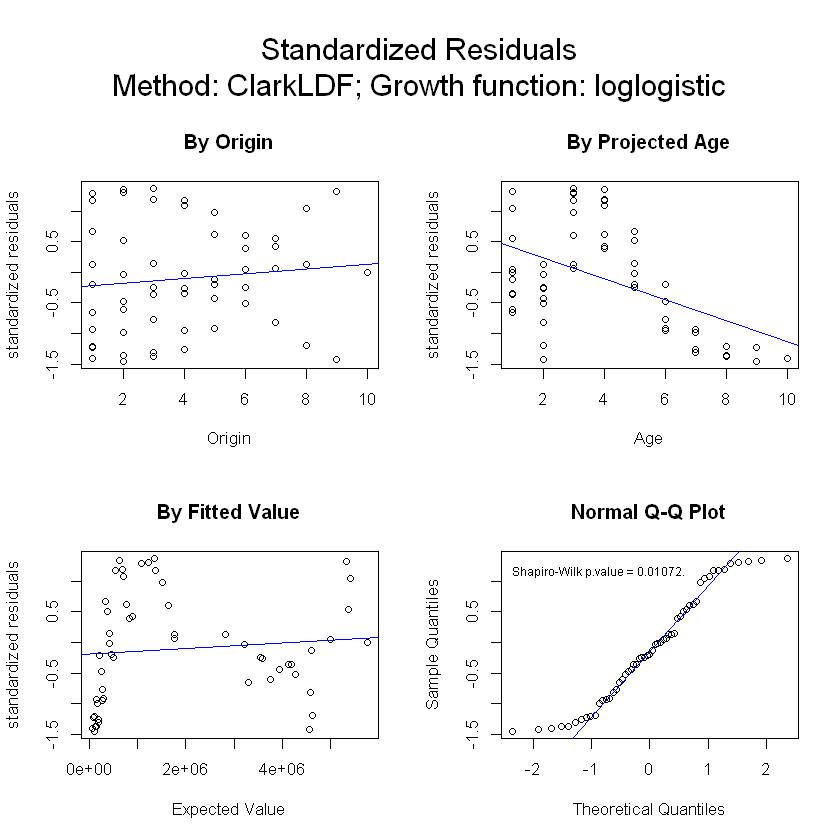

In [44]:
plot(ClarkLDF(ppauto, G="loglogistic"))

### LDF method: Weibull

The Weibull growth curve tends to be faster developing than the log-logistic:

In [45]:
ClarkLDF(ppauto, G="weibull")

,3.506062e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,5.777133e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,9.615183e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,1.618992e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.763751e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.797569e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.506772e-02,0.000000e+00,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.552263e-01,0.000000e+00,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.957728e-01,0.000000e+00
,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.134817e-01
dydom,-3.599853e+05,-5.801021e+05,-8.933522e+05,-1.238487e+06,-1.811064e+06,-2.504679e+06,-3.131226e+06,-3.022555e+06,-1.202014e+06,3.843808e+06


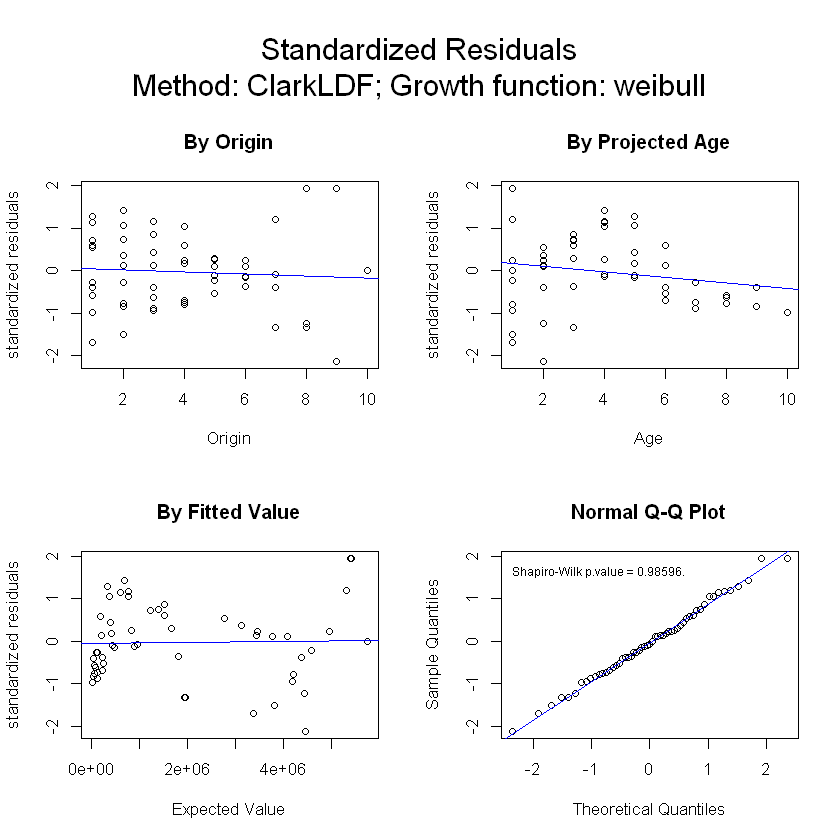

In [46]:
plot(ClarkLDF(ppauto, G="weibull"))